<a href="https://colab.research.google.com/github/AndrewCrossman/Research/blob/main/Lattice_Surface_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.neighbors import KDTree
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
file = "https://raw.githubusercontent.com/AndrewCrossman/Research/main/Sphere100_Au_novoids.stru?token=GHSAT0AAAAAABTRQ5WDBRKMIV46IWEDPEB6YS7LO4A"

In [ ]:
data = pd.read_csv(file, skiprows=3)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)

In [ ]:
data

,y,z,atom,x
0,-2.5,-5.5,AU,-1.0
1,-2.5,-5.5,AU,0.0
2,-2.5,-5.5,AU,1.0
3,-1.5,-5.5,AU,-2.0
4,-2.0,-5.5,AU,-1.5
...,...,...,...,...
3920,0.5,6.0,AU,-0.5
3921,0.0,6.0,AU,0.0
3922,0.5,6.0,AU,0.5
3923,0.0,6.0,AU,1.0


In [ ]:
atom = data.atom
data = data.drop(data.columns[2], axis=1)

In [ ]:
data

,y,z,x
0,-2.5,-5.5,-1.0
1,-2.5,-5.5,0.0
2,-2.5,-5.5,1.0
3,-1.5,-5.5,-2.0
4,-2.0,-5.5,-1.5
...,...,...,...
3920,0.5,6.0,-0.5
3921,0.0,6.0,0.0
3922,0.5,6.0,0.5
3923,0.0,6.0,1.0


In [ ]:
data_ar = data.to_numpy()

In [ ]:
data_ar

array([[-2.5, -5.5, -1. ],
       [-2.5, -5.5,  0. ],
       [-2.5, -5.5,  1. ],
       ...,
       [ 0.5,  6. ,  0.5],
       [ 0. ,  6. ,  1. ],
       [ 1. ,  6. ,  0. ]])

In [ ]:
tree = KDTree(data_ar, leaf_size=2)
all_nn_indices = tree.query_radius(data_ar, r=np.sqrt(2)*1)  
# np.sqrt(2)*1 corresponds to the fourth NN distance in FCC lattice
# instead of writing the lattice parameter, we use 1 because the structure
# file that is used as input measures the distances in lattice parameters

In [ ]:
all_nn_indices[0]

array([ 74,  75,   4,  96,  73,  98,  62,  64,  80,  76,   0,   1,   6,
        79, 100,  78,  77, 102,  81, 104,   5,   3,  99, 101,   7, 103])

In [ ]:
data_ar[0], data_ar[75]

(array([-2.5, -5.5, -1. ]), array([-2.5, -5. , -1.5]))

In [ ]:
np.linalg.norm(data_ar[0])

6.123724356957945

In [ ]:
# values taken from Heinz 2008 (Accurate Simulation of Surfaces and Interfaces ...)
energies = []
distances = []
Energy = 0
E = 5.29/(6.0221408*10**23)*2.611*10**22    # kcal per mole
r0 = 2.951      # angstroms
A = E*r0**12    # E*r0^12 in (kcal * angstrom^12) per mole
B = 2*E*r0**6   #6987    # 2*E*r0^6 in (kcal * angstrom^6) per mole
lp = 4.078900 # lattice parameter

for i in range(len(data_ar)):
  E_n = 0
  for n in all_nn_indices[i]:        # for each neighbor, of group of neighbors, about atom i
    if n!=i:
      dist = np.linalg.norm(data_ar[n]-data_ar[i])  # finds the distance between the atom at index i and index n
      dist = dist*lp
      d3 = dist*dist*dist
      d6 = d3*d3
      d12= d6*d6
      sum = A/d12 - B/d6
      Energy = Energy + sum
      E_n = E_n + sum
  energies.append(E_n)
  distances.append(np.linalg.norm(data_ar[i])*lp)
Energy = Energy/2   # divide by 2 to negate double counting 
energies = energies/2

In [ ]:
Energy # lattice energy in eV

-6384.767784117658

In [ ]:
Energy/3925 # lattice energy per atom in eV

-1.6266924290745626

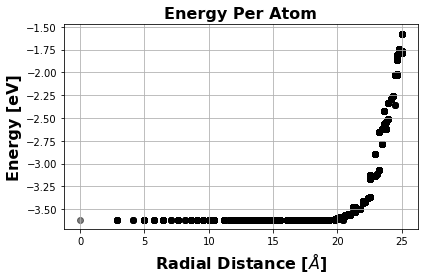

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(distances,energies, alpha=.5, color='black')
ax.set_title(r'Energy Per Atom', fontsize=16, fontweight='bold')
ax.set_xlabel(r'Radial Distance [$\AA$]', fontsize=16, fontweight='bold')
ax.set_ylabel(r'Energy [eV]', fontsize=16, fontweight='bold')
#ax.set_xlim(.9,2.9)
#ax.set_ylim(3,10)
#ax.legend()
ax.grid()
plt.tight_layout()